In [3]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation
from random import shuffle, randint
import pandas as pd
import six
from sklearn.utils import shuffle as mutualShuf
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
%matplotlib inline

## This ipynb processes the data for use in the neural net found at protypeSix-3dConv.ipynb

In [11]:
k = 1 # How many folds in the k-fold x-validation

In [3]:
## I used this to save the array in a smaller file so it doesn't eat all my ram
# df60 = pd.read_pickle("./inData/6060DF_MFMts.pkl")
# coilData = df60["MFMts"].as_matrix()
# ziData = np.zeros([400,2000,19,17])
#
# for i in np.arange(400):
#    for j in np.arange(2000):
#        ziData[i,j] = np.array(coilData[i][j][2])
#
# np.save("./inData/ziData.dat", ziData)
#
# ziClass = df60["Classification"].as_matrix()
# np.save("./inData/ziClass.dat", ziClass)

In [9]:
def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

classData = np.load("./inData/ziClass.npy")
coilData = np.load("./inData/ziData.npy")

# Normalise coilData for each unit time
for i in np.arange(coilData.shape[0]):
    for j in np.arange(coilData.shape[1]):
        coilData[i,j] = normalize(coilData[i,j], axis=1)

In [12]:
illData, healthData = splitData(coilData, classData)
if k == 1:
    illUnseen = np.array(illData[:20])
    healthUnseen = np.array(healthData[:20])
    illData = np.array(illData[20:])
    healthData = np.array(healthData[20:])
    print(illData.shape, healthData.shape,"\n", illUnseen.shape, healthUnseen.shape)
else:
    illData = np.array(illData)
    healthData = np.array(healthData)
    print(illData.shape, healthData.shape)

(176, 2000, 19, 17) (184, 2000, 19, 17) 
 (20, 2000, 19, 17) (20, 2000, 19, 17)


In [13]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def functionTown(illArr, healthArr, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    
    print("ill samples", len(illArr))
    print("healthy samples", len(healthArr))
    
    classData = []
    for i in np.arange(0, len(illArr), 1):
        classData.append(1)
    for i in np.arange(0, len(healthArr), 1):
        classData.append(0)
    ecgData = np.reshape(np.append(illArr, healthArr), (-1, 2000, 19, 17))
    
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)
        
    classDataOH = processClassData(classData)
    return np.array(ecgData), classDataOH, classData
    
ecgData, classDataOH, classData = functionTown(illData, healthData, True)
# Reintegrate the found values...
ecgData = np.reshape(ecgData, (-1,2000,19,17))

if k != 1:
    # Split ecgData into k sets so we can perform k-fold cross validation:
    kfoldData = np.array_split(ecgData, k)
    kfoldLabelsOH = np.array_split(classDataOH, k)
    kfoldLabels = np.array_split(classData, k)

# Get the unseen data:
if k == 1:
    unseenData, unseenClassOH, unseenClass = functionTown(illUnseen, healthUnseen, True)
    #unseenData =  np.cumsum(unseenData, axis=2)
    unseenData = np.reshape(unseenData, (-1,2000,19,17))
    iUnseen, hUnseen = splitData(unseenData, unseenClass)
    unseenHL = np.tile([1,0], (len(hUnseen), 1))
    unseenIL = np.tile([0,1], (len(iUnseen), 1))

ill samples 176
healthy samples 184
ill samples 20
healthy samples 20


In [ ]:
np.save("./inData/3D-conv/ecgData", ecgData)
np.save("./inData/3D-conv/unseenData", unseenData)
np.save("./inData/3D-conv/ecgClass", classData)
np.save("./inData/3D-conv/unseenClass", unseenClass)

# Make a visualisation of the data

In [4]:
ecgData = np.load("./inData/3D-conv/ecgData.npy")
unseenData = np.load("./inData/3D-conv/unseenData.npy")

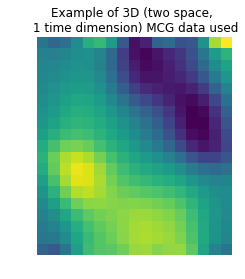

In [5]:
ppt=100
fig = plt.figure()
data = ecgData[ppt,0]
im = plt.imshow(data)

def animate(i):
    data = ecgData[ppt,i]
    im.set_data(data)
    return im

plt.axis("off")
plt.title("Example of 3D (two space, \n 1 time dimension) MCG data used")
anim = animation.FuncAnimation(fig, animate, frames=np.arange(2000)[::10], repeat=False)
anim.save("/tmp/3D-Data-Example.mp4")